Сначала реализуем CycleGAN и проверим его на датасете 

https://www.kaggle.com/balraj98/monet2photo

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as tt
import torch.optim as optim
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
api_token = {"username":"sergeychernykh","key":"90fa93cfe9ec98edd28b944ea978350c"}

import json

with open('/kaggle/working/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /kaggle/working/kaggle.json
!rm -rf /root/.kaggle
!mkdir /root/.kaggle  

In [3]:
!mv kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d balraj98/monet2photo

 99%|███████████████████████████████████████▋| 289M/291M [00:10<00:00, 33.3MB/s]
100%|████████████████████████████████████████| 291M/291M [00:10<00:00, 28.7MB/s]


In [5]:
! unzip -qq '/kaggle/working/monet2photo.zip' 


In [6]:
!mkdir train test

In [7]:
! mv trainA train

In [8]:
! mv trainB train

In [9]:
! mv testA test
! mv testB test

In [10]:
! mkdir saved_images


Статья про CycleGan, по которой я буду его писать https://arxiv.org/pdf/1703.10593.pdf

Discriminator

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride=stride, padding=1, bias=True, padding_mode='reflect'), # kernel_size 4 from paper, padding_mode='reflect' helps to reduce artefacts
            nn.InstanceNorm2d(out_channels), # from paper
            nn.LeakyReLU(0.2), # from paper
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='reflect',
            ),
            nn.LeakyReLU(0.2),

            ConvBlock(
                in_channels=features[0], 
                out_channels=features[1], 
                stride=2
            ),
            
            ConvBlock(
                in_channels=features[1],
                out_channels=features[2],
                stride=2
            ),
            
            ConvBlock(
                in_channels=features[2],
                out_channels=features[3], 
                stride=1
            ),

            nn.Conv2d(
                in_channels=features[3],
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode='reflect',
            ),
        )
        
    def forward(self, x):
        return torch.sigmoid(self.model(x))


        


In [12]:
def test():
    x = torch.rand((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(model)
    print(preds.shape)

In [13]:
test()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (4): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=Fals

Generator

In [14]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down_sampling=True, use_activation=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode='reflect', **kwargs) if down_sampling
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_activation else nn.Identity()
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block = nn.Sequential(
            Block(in_channels, in_channels, kernel_size=4, padding=1),
            Block(in_channels, in_channels,down_sampling=False, kernel_size=4, padding=1),
        )
    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, channels, features=64, residuals=9):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=7, stride=1, padding=3, padding_mode='reflect'),
            nn.ReLU(inplace=True),
        )
        self.layers_down = nn.ModuleList(
            [
                Block(features, 2*features, down_sampling=True, kernel_size=3, stride=2, padding=1),
                Block(2*features, 4*features, down_sampling=True, kernel_size=3, stride=2, padding=1)
            ]
        )
        self.residuals_layers = nn.Sequential(
            *[ResidualBlock(4*features) for _ in range(residuals)]
        )
        self.layers_up = nn.ModuleList(
            [
                Block(4*features, 2*features, down_sampling=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                Block(2*features, features, down_sampling=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.to_rgb = nn.Conv2d(features, channels, kernel_size=7, stride=1, padding=3, padding_mode='reflect')
    def forward(self, x):
        x = self.layer1(x)
        for layer in self.layers_down:
            x = layer(x)
        x = self.residuals_layers(x)
        for layer in self.layers_up:
            x = layer(x)
        x = self.to_rgb(x)

        return torch.tanh(x)

        

In [15]:
def test():
    inc = 3
    img = 256
    x = torch.rand((2, inc, img, img))
    gen = Generator(inc, residuals=9)
    print(gen)
    print(gen(x).shape)


In [16]:
test()

Generator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (layers_down): ModuleList(
    (0): Block(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): Block(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
  )
  (residuals_layers): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Block(
          (conv): Sequential(
            (0): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), paddi

some parametrs and loaders

In [1]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "train/"
VAL_DIR = "test/"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 2
LAMBDA_CYCLE = 10
NUM_WORKERS = 2
NUM_EPOCHS = 30
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN_M = "genm.pth.tar"
CHECKPOINT_GEN_P = "genp.pth.tar"
CHECKPOINT_DISC_M = "criticm.pth.tar"
CHECKPOINT_DISC_P = "criticp.pth.tar"

NameError: name 'torch' is not defined

In [18]:
transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

In [19]:
def save_checkpoint(model, optimizer, filename='weights.tar'):
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    for param in optimizer.param_groups:
        param['lr'] = lr

In [20]:
class MonetToPhoto(Dataset):
    def __init__(self, root_monet, root_photo, transform):
        self.root_monet = root_monet
        self.root_photo = root_photo
        self.transform = transform

        self.monet_images = os.listdir(root_monet)
        self.photo_images = os.listdir(root_photo)

        self.length_dataset = max(len(self.monet_images), len(self.photo_images))
        self.monet_length = len(self.monet_images)
        self.photo_length = len(self.photo_images)

    def __len__(self):
        return self.length_dataset
    
    def __getitem__(self, index):
        monet_img = self.monet_images[index % self.monet_length]
        photo_img = self.photo_images[index % self.photo_length]

        monet_path = os.path.join(self.root_monet, monet_img)
        photo_path = os.path.join(self.root_photo, photo_img)

        monet_img = np.array(Image.open(monet_path).convert('RGB'))
        photo_img = np.array(Image.open(photo_path).convert('RGB'))

        if self.transform:
            augmentation = self.transform(image=monet_img, image0=photo_img)
            monet_img = augmentation['image']
            photo_img = augmentation['image0']

        return monet_img, photo_img 

time to write train 

In [21]:
def show_images(images, nmax, h=5, w=5):
    name = ["monet", "fake_monet", "photo", "fake_photo"]
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, nmax+1):
        img = images[i-1][0].cpu().detach().permute(1, 2, 0)
        fig.add_subplot(2, 2, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(name[i-1])
    plt.show()

In [22]:

def train(epoches, disc_M, disc_P, gen_M, gen_P, loader, opt_d, opt_g, L1, mse):
    #gen_l_m = np.array([]),
    #gen_l_p = np.array([]), 
    #disc = np.array([]), 
    #cycle_l_m = np.array([]), 
    #cycle_l_p = np.array([]),
    #identity_l_m = np.array([]),
    #identity_l_p = np.array([]),
    loss = np.array([])
    for epoch in tqdm(range(epoches)):
        show = True
        for monet, photo in tqdm(loader):
            monet = monet.to(DEVICE)
            photo = photo.to(DEVICE)
            # train dicriminator
            fake_monet = gen_M(photo)
            disc_m_real = disc_M(monet)
            disc_m_fake = disc_M(fake_monet.detach())
            disc_m_real_loss = mse(disc_m_real, torch.ones_like(disc_m_real))
            disc_m_fake_loss = mse(disc_m_fake, torch.zeros_like(disc_m_fake))
            disc_loss = disc_m_real_loss + disc_m_fake_loss
            


            fake_photo = gen_P(monet)
            disc_p_real = disc_P(photo)
            disc_p_fake = disc_P(fake_photo.detach())
            disc_p_real_loss = mse(disc_p_real, torch.ones_like(disc_p_real))
            disc_p_fake_loss = mse(disc_p_fake, torch.zeros_like(disc_p_fake))
            disc_loss += disc_p_real_loss + disc_p_fake_loss
            disc_loss /= 2

            opt_d.zero_grad()
            disc_loss.backward()
            opt_d.step()
            #np.append(disc, disc_loss.detach().cpu())


            # train genarator
            disc_m_fake = disc_M(fake_monet)
            disc_p_fake = disc_P(fake_photo)
            gen_loss_m = mse(disc_m_fake, torch.ones_like(disc_m_fake))
            gen_loss_p = mse(disc_p_fake, torch.ones_like(disc_p_fake))
            #np.append(gen_l_p, gen_loss_p.detach().cpu())
            #np.append(gen_l_m, gen_loss_m.detach().cpu())

            # cycle loss\
            cycle_monet = gen_M(fake_photo)
            cycle_photo = gen_P(fake_monet)
            cycle_loss_m = L1(monet, cycle_monet)
            cycle_loss_p = L1(photo, cycle_photo)
            #np.append(cycle_l_m, cycle_loss_m.detach().cpu())
            #np.append(cycle_l_p, cycle_loss_p.detach().cpu())

            # identity loss
            identity_m = gen_M(monet)
            identity_p = gen_P(photo)
            identity_loss_m = L1(monet, identity_m)
            identity_loss_p = L1(photo, identity_p)
            #np.append(identity_l_m, identity_loss_m.detach().cpu())
            #np.append(identity_l_p, identity_loss_p.detach().cpu())

            # combinded loss
            gen_loss = gen_loss_m + gen_loss_p + (cycle_loss_m + cycle_loss_p)*LAMBDA_CYCLE + (identity_loss_m + identity_loss_p)*LAMBDA_IDENTITY
                
            opt_g.zero_grad()
            gen_loss.backward()
            opt_g.step()
            np.append(loss, gen_loss.detach().cpu())
            
            if show:
                save_image(fake_monet*0.5 + 0.5, f'saved_images/monet_{epoch}.png')
                save_image(fake_photo*0.5 + 0.5, f'saved_images/photo_{epoch}.png')
                show_images([monet, fake_monet * 0.5 + 0.5, photo, fake_photo * 0.5 + 0.5], 4)
                show = False
            
            del monet
            del photo
            del fake_monet
            del fake_photo
            torch.cuda.empty_cache()
    #return gen_l_m, gen_l_p, disc, cycle_l_m, cycle_l_p, identity_l_m, identity_l_p, loss
    return loss

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/6287 [00:00<?, ?it/s]

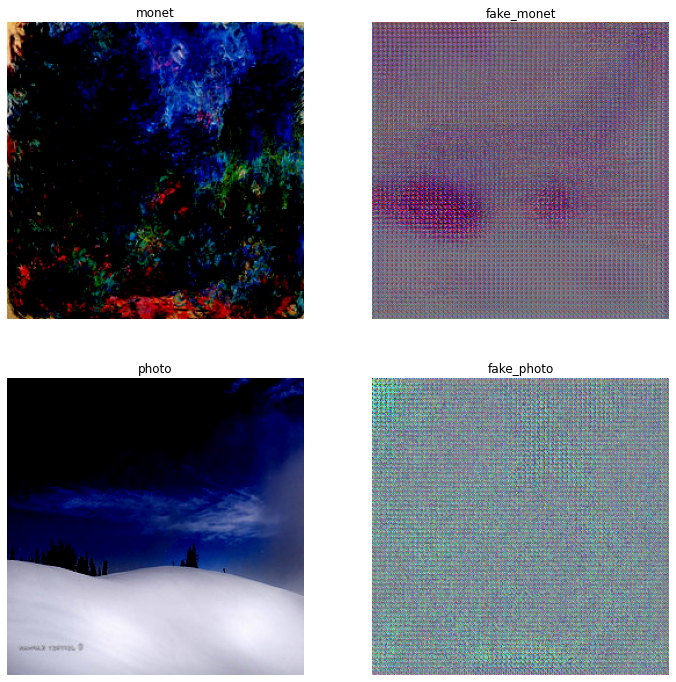

  0%|          | 0/6287 [00:00<?, ?it/s]

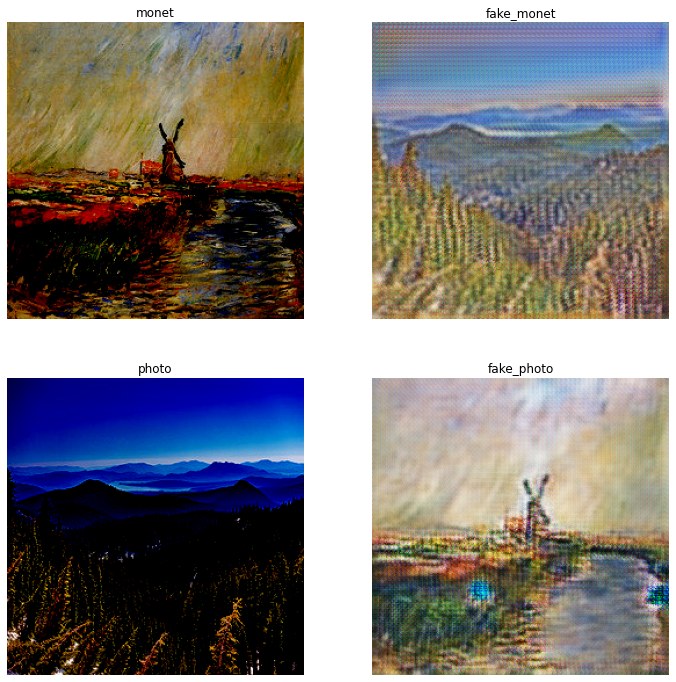

In [ ]:
discriminator_monet = Discriminator(in_channels=3).to(DEVICE)
discriminator_photo = Discriminator(in_channels=3).to(DEVICE)
generator_monet = Generator(channels=3, residuals=9).to(DEVICE)
generator_photo = Generator(channels=3, residuals=9).to(DEVICE)

opt_discriminator = optim.Adam(
    list(discriminator_monet.parameters()) + list(discriminator_photo.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)
opt_generator = optim.Adam(
    list(generator_monet.parameters()) + list(generator_photo.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

if LOAD_MODEL:
    load_checkpoint()

if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_GEN_M, generator_monet, opt_generator, LEARNING_RATE,)
    load_checkpoint(CHECKPOINT_GEN_P, generator_photo, opt_generator, LEARNING_RATE,)
    load_checkpoint(CHECKPOINT_DISC_M, discriminator_monet, opt_discriminator, LEARNING_RATE,)
    load_checkpoint(CHECKPOINT_DISC_P, discriminator_photo, opt_discriminator, LEARNING_RATE,)

dataset = MonetToPhoto(root_monet=TRAIN_DIR+'trainA', root_photo=TRAIN_DIR+'trainB', transform=transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=True)

history = train(NUM_EPOCHS ,discriminator_monet, discriminator_photo, generator_monet, generator_photo, loader, opt_discriminator, opt_generator, L1, mse)

if SAVE_MODEL:
    save_checkpoint(discriminator_monet, opt_discriminator, filename=CHECKPOINT_DISC_M)
    save_checkpoint(discriminator_photo, opt_discriminator, filename=CHECKPOINT_DISC_P)
    save_checkpoint(generator_monet, opt_generator, filename=CHECKPOINT_GEN_M)
    save_checkpoint(generator_photo, opt_generator, filename=CHECKPOINT_GEN_P)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
! ls saved_images

In [ ]:
for _, _, files in os.walk(os.path.normpath('/kaggle/working/saved_images')):
    print(files)

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.cpu().detach()[:nmax] *0.5 + 0.5 , nrow=8).permute(1, 2, 0))

In [ ]:
for _, _, imgs in os.walk(os.path.normpath('/kaggle/working/testA')):
    print(imgs)
    for img in imgs:
        path = os.path.normpath('/kaggle/working/testA/'+img)
        img = np.array(Image.open(path).convert('RGB'))
        photo_from_monet = disc_P(img) * 0.5 + 0.5
        show_images(photo_from_monet)
    